# TorchSimulation

In [1]:
import sys
import os
sys.path.append('/home/xiaoxinyu/TorchFiber')

import torch
from src.TorchSimulation.transmitter import QAM, simpleWDMTx
from src.TorchSimulation.channel import manakov_ssf
from src.TorchSimulation.receiver import simpleRx
import matplotlib.pyplot as plt, numpy as np

In [ ]:
tx_data = simpleWDMTx(123, batch=10, M=16, Nbits=400000, sps=32, Nch=5, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0, Ai=1, Vpi=2, Vb=-2, Ntaps=4096, roll=0.1, pulse_type='rc', device='cuda:0')
trans_data = manakov_ssf(tx_data, seed=121, Ltotal=2000, Lspan=80, hz=0.5, alpha=0.2, D=16.5, gamma=1.3, Fc=193.1e12, amp='edfa', NF=4.5, order=1, openPMD=False, Dpmd=3, Lcorr=0.1, device='cuda:0')
rx_data = simpleRx(234, trans_data['signal'], tx_data['config'], 2, 2, method='filtering')

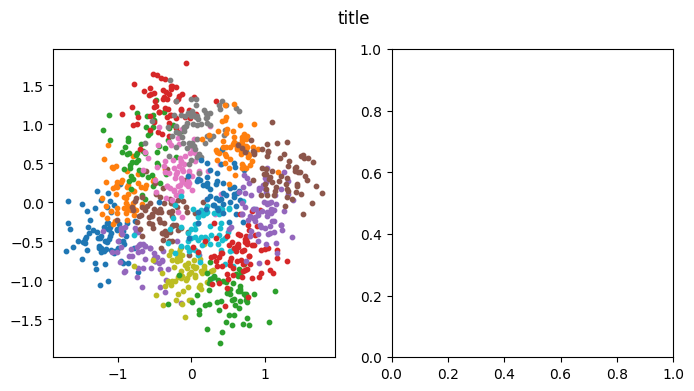

In [25]:
import pickle
from src.JaxSimulation.utils import show_symb
from src.TorchDSP.baselines import CDC, DBP
import torch, matplotlib.pyplot as plt, numpy as np


y_cdc = CDC(rx_data['signal'], torch.ones(10, device='cuda:0') * tx_data['config']['Rs'] * rx_data['config']['rx_sps'], trans_data['config']['Ltotal']*1e3)
truth = tx_data['SymbTx']
show_symb(y_cdc[0,0:2000:2].to('cpu'), truth[0,0:1000,rx_data['config']['chid']].to('cpu'))

# JaxSimulation

In [38]:
from src.JaxSimulation.transmitter import QAM, simpleWDMTx, choose_sps
from src.JaxSimulation.channel import manakov_ssf, choose_dz, get_beta2
from src.JaxSimulation.receiver import simpleRx, sml_dataset
from src.JaxSimulation.models import CDCBPS,CDCMIMO,DBPMIMO, BER
import src.JaxSimulation.DataLoader  as DL
import jax.numpy as jnp, jax.random as rd, numpy as np

batch = 1
Nmodes = 1
M = 16                   # QAM format.
Ltotal = 80*25           # Total Length. [km]   !TODO  ################################################################################ !!!!
Lspan = 80               # Length per span. [km]
alpha = 0.2              # Attenuation parameter. [dB/km]
D = 16.5 * 1             # Dispersion parameter.  [ps/nm/km]
Dpmd = 3                 # PMD parameter. [ps/sqrt(km)]
PMD = False              # Simulation PMD or not.  True or False.
Lcorr = 0.1              # Fiber Correlation length.     [km]
Fc = 299792458/1550E-9   # Central frequency             [Hz]
gamma = 1.6567           # Nonlinear paramerter.         [/W/km]
amp = 'edfa'             # Amplifier type. 'edfa', 'ideal', or None. [default:'edfa']
NF = 4.5                 # EDFA Noise Figure. [dB]
beta2 = get_beta2(D, Fc) # [s^2/km]
Pch_dBm = 8                # Transmit power. [dBm]``
Nch = 19
freqspace = 220e9
Rs = 190e9

In [39]:
sps = choose_sps(Nch, freqspace, Rs)
print(f'Transmitter sps: {sps}')

dz = choose_dz(freqspace, Lspan, Pch_dBm, Nch, beta2, gamma)
print(f'SSFM dz: {dz}')

Transmitter sps: 32
SSFM dz: 0.00048828125


In [40]:
tx_data = simpleWDMTx(False, rd.PRNGKey(123), batch, M, 400000, sps, Nch, Nmodes, Rs, freqspace, Pch_dBm)

Sample rate fa: 6.08e+12, Cut off frequency fc: 2.09e+12, fa > 2fc: True
 simpleWDMTx complete, time cost(s):0.7345623970031738


In [33]:
# batch  = 10
for i in range(10, 6, -1):
    print(f'SSFM dz = {dz*2**i} km')
    trans_data = manakov_ssf(tx_data, rd.PRNGKey(321), Ltotal, Lspan, dz*2**i, alpha, D, gamma, Fc, order=1)

rx_data = simpleRx(trans_data['signal'], tx_data['config'], rd.PRNGKey(4), chid=Nch//2, rx_sps=2)

SSFM dz = 0.5 km
 manakov_ssf complete, time cost(s):29.655458211898804
SSFM dz = 0.25 km
 manakov_ssf complete, time cost(s):59.074787616729736
SSFM dz = 0.125 km
 manakov_ssf complete, time cost(s):116.08079767227173
SSFM dz = 0.0625 km
 manakov_ssf complete, time cost(s):232.46887183189392


In [13]:
import jax
data = sml_dataset(jax.device_get(rx_data['signal']), tx_data['SymbTx'], tx_data['config'], trans_data['config'], rx_data['config'])

In [15]:
import pickle 

pickle.dump(data, open('data.pkl', 'wb'))

In [5]:
import jax, jax.numpy as jnp
from jax._src.config import config

config.update("jax_enable_x64", True)

# JaxDSP

In [1]:
import pickle, jax
from JaxSimulation.utils import show_symb
from JaxSimulation.transmitter import QAM, simpleWDMTx
from JaxSimulation.channel import manakov_ssf, choose_dz, get_beta2
from JaxSimulation.receiver import simpleRx, sml_dataset, DataInput
from JaxSimulation.models import CDCBPS,CDCMIMO,DBPMIMO, BER


data = pickle.load(open('data.pkl', 'rb'))

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [7]:
data0 = DataInput(data.y[0], data.x[0], data.w0, data.a)

In [19]:
a = CDCMIMO(data0, lead_symbols=2000)
truth = data0.x
BER(a.val[2000:], truth[a.t.start:truth.shape[-2] + a.t.stop][2000:])

 CDC complete, time cost(s):0.0032863616943359375


,BER,SER,Qsq,SNR
dim0,0.034125,0.13189907,5.217384,11.522441


In [20]:
a = DBPMIMO(data0, steps=25*4, lead_symbols=2000)
truth = data0.x
BER(a.val[2000:], truth[a.t.start:truth.shape[-2] + a.t.stop][2000:])

 DBP complete, time cost(s):0.8194394111633301


,BER,SER,Qsq,SNR
dim0,0.003488,0.013900228,8.620857,15.328574


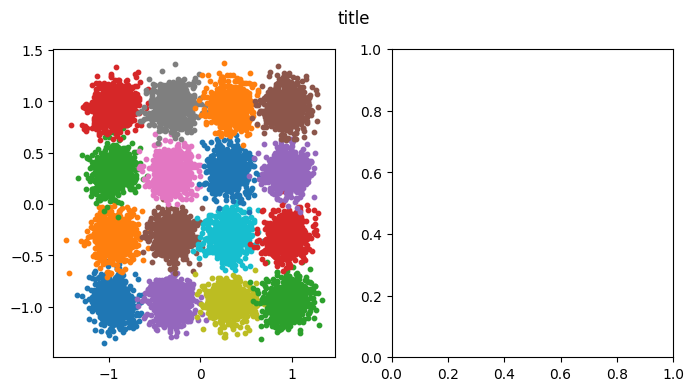

In [28]:
show_symb(jax.device_get(a.val)[2000:][0:10000], truth[a.t.start:truth.shape[-2] + a.t.stop][2000:][0:10000])

# TorchDSP

In [1]:
import pickle
from JaxSimulation.utils import show_symb
from TorchDSP.baselines import CDC, DBP, CDCDSP, DBPDSP
from TorchSimulation.receiver import BER, QAM
import torch, matplotlib.pyplot as plt, numpy as np

data = pickle.load(open('data.pkl', 'rb'))
device = 'cpu'
y_cdc = CDC(torch.tensor(data.y).to(device), torch.ones(10, device=device) * data.a['samplerate'], data.a['distance'])

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
y_cdcdsp = CDCDSP(torch.tensor(data.y[0:1]).to(device), torch.tensor(data.x[0:1]).to(device), data.a['distance'], torch.ones(1, device=device) * data.a['samplerate'], data.a['sps'])

In [3]:
y_dbpdsp = DBPDSP(torch.tensor(data.y[0:1]).to(device), torch.tensor(data.x[0:1]).to(device), data.a['distance'], 10e3,  torch.ones(1, device=device) * data.a['samplerate'], data.a['sps'])

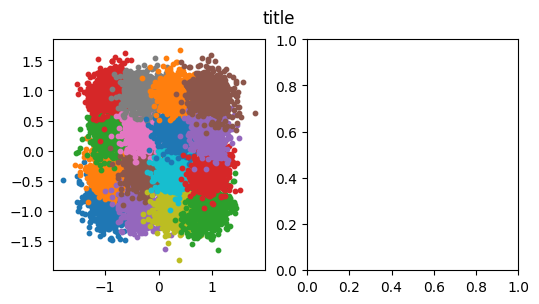

In [4]:
show_symb(y_cdcdsp.val[0,2000:12000], data.x[0,y_cdcdsp.t.start: y_cdcdsp.t.stop][2000:12000], figsize=(6,3))

In [5]:
BER(y_cdcdsp.val[0,2000:12000], torch.tensor(data.x[0,y_cdcdsp.t.start: y_cdcdsp.t.stop][2000:12000]))

,BER,SER,Qsq,SNR
dim0,0.034178,0.132313,5.214052,11.459141


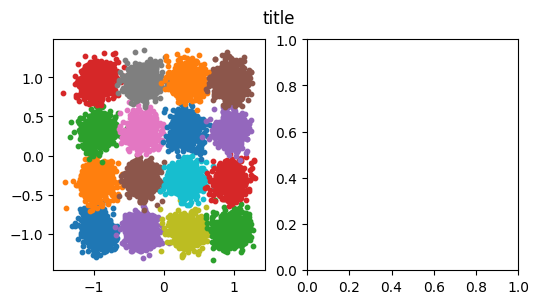

In [6]:
show_symb(y_dbpdsp.val[0,2000:12000], data.x[0,y_dbpdsp.t.start: y_dbpdsp.t.stop][2000:12000], figsize=(6,3))

In [8]:
BER(y_dbpdsp.val[0,2000:120000], torch.tensor(data.x[0,y_dbpdsp.t.start: y_dbpdsp.t.stop][2000:120000]))

,BER,SER,Qsq,SNR
dim0,0.002559,0.010196,8.941609,15.708584


# Data Loader

In [1]:
import JaxSimulation.DataLoader as DL

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
data, var = DL.Generate_Data('batch2', Nch=[1,3,5], Rs=[40, 80], SF=1.2, mode=1, batch_id=[0], power=[-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8], path=None, merge=False, transform=None, dbpsteps=None)

In [5]:
import jax, optax, pickle, jax.random as rd, jax.numpy as jnp, flax.linen as nn, numpy as np
from jax._src.config import config
from JaxSimulation.receiver import BER, get_dataset, merge_dataset
from JaxSimulation.core import MySignal,SigTime,wrap_signal
from JaxSimulation.models import CDCBPS,CDCMIMO,DBPMIMO, DBPBPS, BER, piecewise_constant, DBP, mask_signal, mimoaf,downsamp, DBP_transform, wrap_signal
import JaxSimulation.DataLoader  as DL


# # dataset
mark = 'batch2'
Q = {}
Q['batch_id'] = 0
Q['p'] = [-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8]
Q['Nch'] = [1,3,5,7,9,11,13,15]
Q['Rs'] = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
Q['SF'] = 1.2
Q['mode'] = 1
stps = [5, 6, 7, 8, 9, 10, 20, 40, 80]
spans = 25



for Nch in Q['Nch']:
    for Rs in Q['Rs']:
        print(f'Nch={Nch}, Rs={Rs}')
        test_data, _ = DL.Generate_Data(mark=mark, Nch=Nch, Rs=Rs, SF=Q['SF'], mode=Q['mode'], batch_id=Q['batch_id'], power=Q['p'])

        Q[f'Nch={Nch}, Rs={Rs}'] = {}
        for scale in [0,0.1,0.2]:
            Q[f'Nch={Nch}, Rs={Rs}'][f'CDC_{scale}'] = []
            for n in stps: Q[f'Nch={Nch}, Rs={Rs}'][f'DBP stps={n}_{scale}'] = []
    
        for dataset in test_data:
            truth = dataset.x
            a = CDCMIMO(dataset, lead_symbols=2000)
            Q[f'Nch={Nch}, Rs={Rs}']['CDC_0'].append(BER(a.val[0:], truth[a.t.start:truth.shape[-2] + a.t.stop][0:])['Qsq']['dim0'])
            Q[f'Nch={Nch}, Rs={Rs}']['CDC_0.1'].append(BER(a.val[10000:], truth[a.t.start:truth.shape[-2] + a.t.stop][10000:])['Qsq']['dim0'])
            Q[f'Nch={Nch}, Rs={Rs}']['CDC_0.2'].append(BER(a.val[20000:], truth[a.t.start:truth.shape[-2] + a.t.stop][20000:])['Qsq']['dim0'])

            for n in stps:
                a = DBPMIMO(dataset,steps=n*spans, lead_symbols=2000)
                Q[f'Nch={Nch}, Rs={Rs}'][f'DBP stps={n}_0'].append(BER(a.val[0:], truth[a.t.start:truth.shape[-2] + a.t.stop][0:])['Qsq']['dim0'])
                Q[f'Nch={Nch}, Rs={Rs}'][f'DBP stps={n}_0.1'].append(BER(a.val[10000:], truth[a.t.start:truth.shape[-2] + a.t.stop][10000:])['Qsq']['dim0'])
                Q[f'Nch={Nch}, Rs={Rs}'][f'DBP stps={n}_0.2'].append(BER(a.val[20000:], truth[a.t.start:truth.shape[-2] + a.t.stop][20000:])['Qsq']['dim0'])

SF = Q['SF']
mode = Q['mode']
pickle.dump(Q, open(f'Q_{mark}_SF{SF}_mode{mode}_stps5-10', 'wb'))

102

In [7]:
import pickle, matplotlib.pyplot as plt, numpy as np

Q = pickle.load(open('Q_batch2_SF1.2_mode1_stps5-10', 'rb'))

In [16]:
Q.keys()

dict_keys(['batch_id', 'p', 'Nch', 'Rs', 'SF', 'mode', 'Nch=7, Rs=20', 'Nch=7, Rs=40', 'Nch=7, Rs=80'])

(0.0, 10.0)

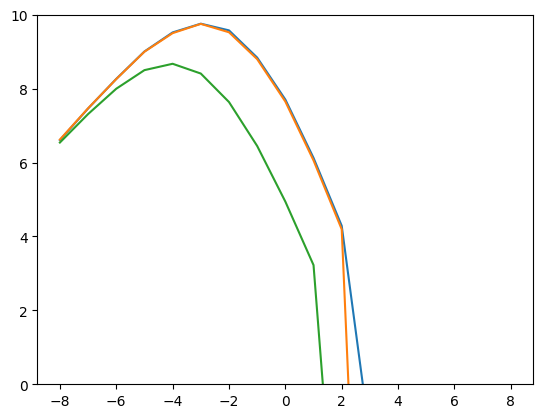

In [18]:
plt.plot(Q['p'], Q['Nch=7, Rs=40']['DBP stps=40_0.2'])
plt.plot(Q['p'], Q['Nch=7, Rs=40']['DBP stps=10_0.2'])
plt.plot(Q['p'], Q['Nch=7, Rs=40']['CDC_0.2'])
plt.ylim(0,10)